In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [14]:
# labeled_bg_sentences_df = pd.read_csv('../data/anotated_datasets/labeled_bulgarian_sentences.csv')
# labeled_framar_df = pd.read_csv('../data/anotated_datasets/framar_labeled_sentences.csv')
# labeled_proud_bg_sentences_df = pd.read_csv('../data/anotated_datasets/proudbg_labeled_sentences.csv')
# non_toxic_sentences_df = pd.read_csv('../data/anotated_datasets/non_toxic_labeled_sentences.csv')
# frames = [labeled_bg_sentences_df, labeled_framar_df, labeled_proud_bg_sentences_df, non_toxic_sentences_df]
# df = pd.concat(frames)

# df.to_csv('../data/toxic_sentences.csv', index=False)


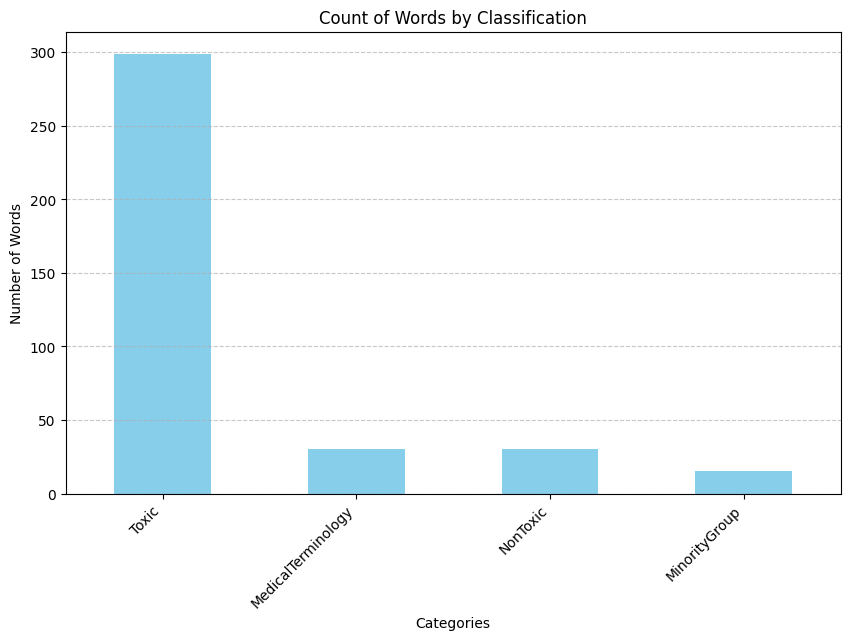

In [15]:
columns = ['Index', 'Word', 'Toxic', 'MedicalTerminology', 'NonToxic', 'MinorityGroup']

def censor_word(word):
    mid = len(word) // 2
    return word[:mid] + '*' + word[mid+1:]

output_file_path = '../data/toxic-words.csv'
data = pd.read_csv(output_file_path)

data['Word'] = data['Word'].apply(censor_word)

data.head()

classification_columns = columns[2:]
data[classification_columns] = data[classification_columns].astype(int)
category_counts = data[classification_columns].sum()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Words by Classification')
plt.xlabel('Categories')
plt.ylabel('Number of Words')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/7g/0sqgzqg91cg7_drxrd6npptr0000gn/T/ipykernel_99862/3352444782.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Word_Num'] = filtered_data['Word'].map(word_to_num_75)


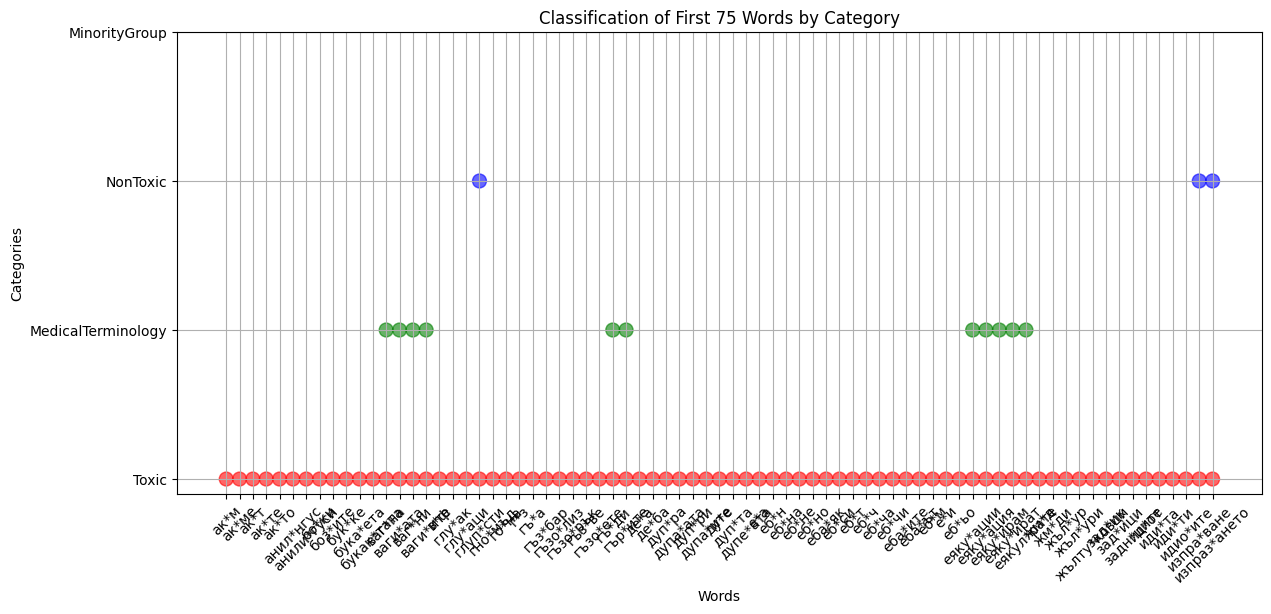

In [16]:
long_format = data.melt(id_vars=['Word'], value_vars=classification_columns, var_name='Category', value_name='Is_Classified')
long_format = long_format[long_format['Is_Classified'] == 1]

word_to_num = {word: i for i, word in enumerate(data['Word'].unique(), 1)}
long_format['Word_Num'] = long_format['Word'].map(word_to_num)

category_to_color = {
    'Toxic': 'red',
    'MedicalTerminology': 'green',
    'NonToxic': 'blue',
    'MinorityGroup': 'purple'
}
long_format['Color'] = long_format['Category'].map(category_to_color)


first_75_words = data['Word'].unique()[:75]
filtered_data = long_format[long_format['Word'].isin(first_75_words)]


word_to_num_75 = {word: i for i, word in enumerate(first_75_words, 1)}
filtered_data['Word_Num'] = filtered_data['Word'].map(word_to_num_75)

plt.figure(figsize=(14, 6))
plt.scatter(filtered_data['Word_Num'], filtered_data['Category'], c=filtered_data['Color'], s=100, alpha=0.6)
plt.title('Classification of First 75 Words by Category')
plt.xlabel('Words')
plt.ylabel('Categories')
plt.xticks(ticks=np.arange(1, len(word_to_num_75) + 1), labels=word_to_num_75.keys(), rotation=45)
plt.yticks(ticks=classification_columns, labels=classification_columns)
plt.grid(True)
plt.show()


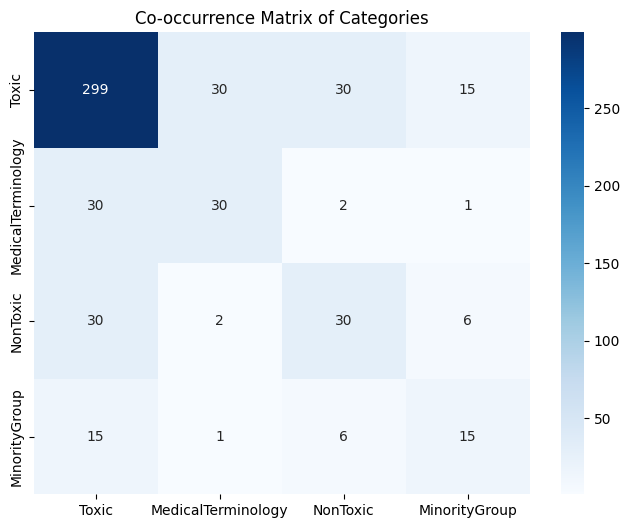

In [17]:
co_occurrence_matrix = data[classification_columns].T.dot(data[classification_columns])

plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Co-occurrence Matrix of Categories")
plt.show()

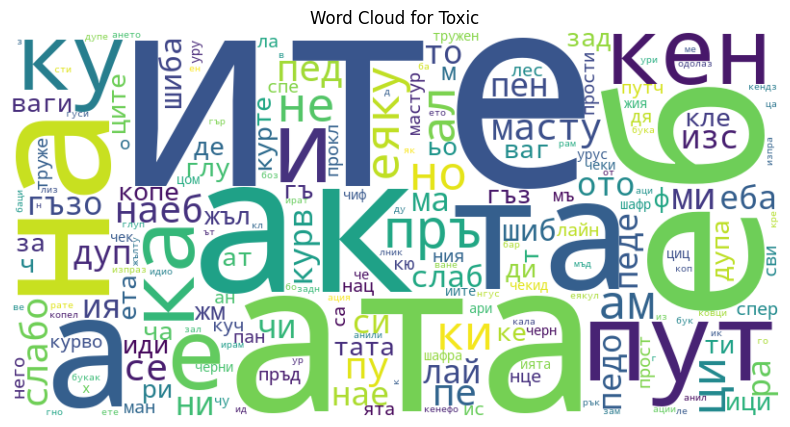

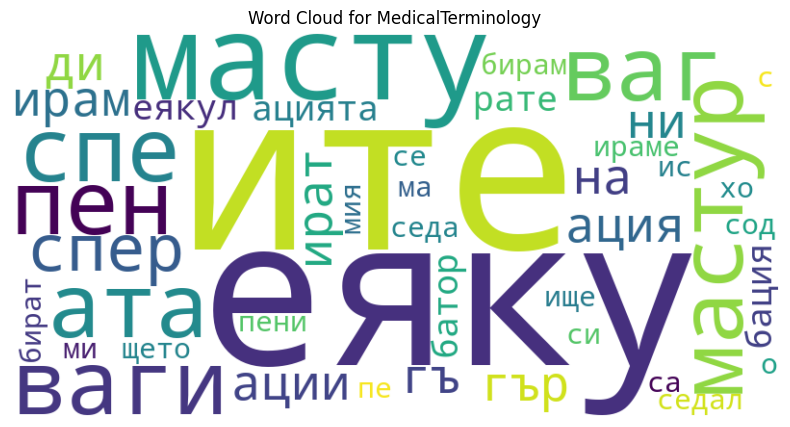

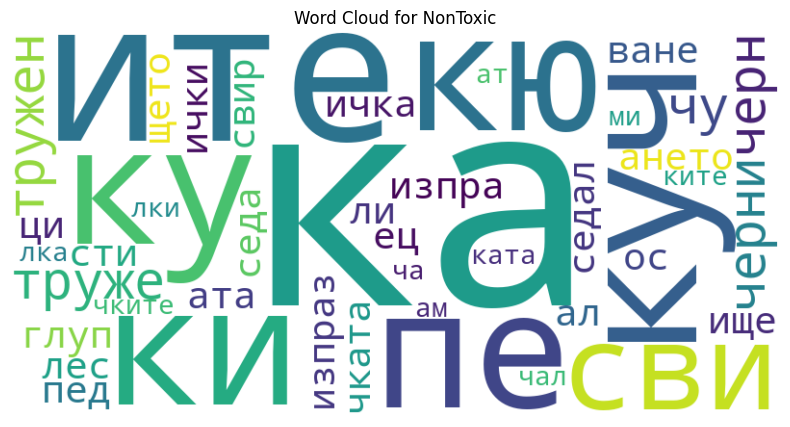

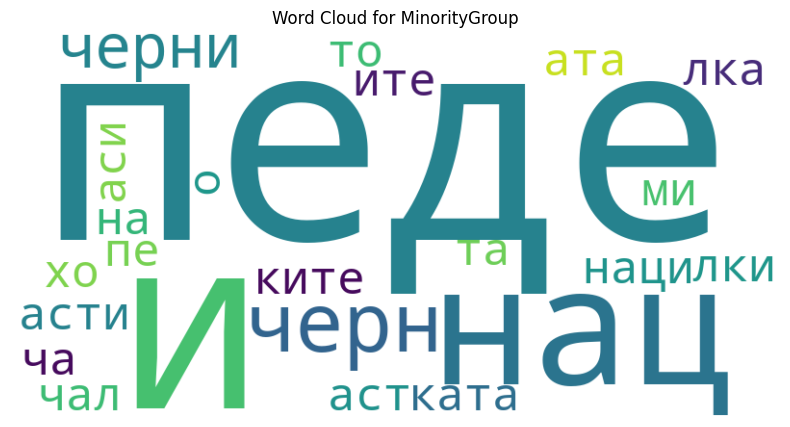

In [18]:
def generate_word_cloud(category):
    filtered_words = data[data[category] == 1]['Word']
    text = ' '.join(filtered_words)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {category}")
    plt.show()

for category in classification_columns:
    generate_word_cloud(category)


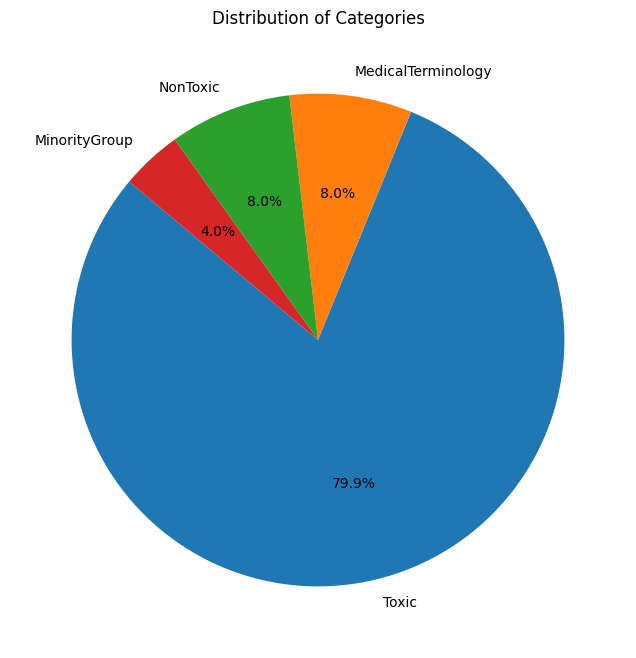

In [19]:
category_counts = data[classification_columns].sum()
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.show()


# EDA sentences

In [20]:
label_columns = ['Toxic', 'MedicalTerminology', 'NonToxic', 'MinorityGroup']
sentences_file_path = '../data/toxic_sentences.csv'
toxic_sentences = pd.read_csv(sentences_file_path)

In [21]:
label_distribution = toxic_sentences[label_columns].sum()
print(label_distribution, '\n')
toxic_sentences['sentence_length'] = toxic_sentences['text'].apply(len)
print(toxic_sentences['sentence_length'].describe(), '\n')
label_correlations = toxic_sentences[label_columns].corr()
print(label_correlations)

Toxic                 2358.0
MedicalTerminology    1222.0
NonToxic               452.0
MinorityGroup          135.0
dtype: float64 

count    4383.000000
mean       98.815195
std        81.050328
min         3.000000
25%        48.000000
50%        79.000000
75%       127.000000
max      1535.000000
Name: sentence_length, dtype: float64 

                       Toxic  MedicalTerminology  NonToxic  MinorityGroup
Toxic               1.000000           -0.666856 -0.362903      -0.187071
MedicalTerminology -0.666856            1.000000 -0.210834      -0.110840
NonToxic           -0.362903           -0.210834  1.000000      -0.060449
MinorityGroup      -0.187071           -0.110840 -0.060449       1.000000


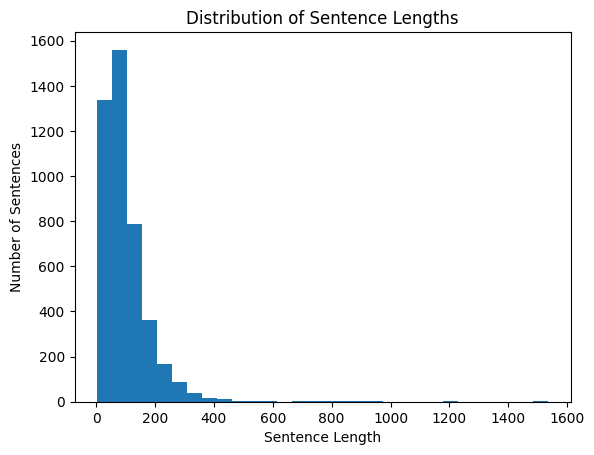

In [22]:

plt.hist(toxic_sentences['sentence_length'], bins=30)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.show()

In [23]:
def encode_labels(row):
    if row['Toxic'] == 1:
        return 0
    elif row['MedicalTerminology'] == 1:
        return 1
    elif row['NonToxic'] == 1:
        return 2
    elif row['MinorityGroup'] == 1:
        return 3
    else:
        return -1
    
toxic_sentences['labels'] = toxic_sentences.apply(encode_labels, axis=1)
toxic_sentences = toxic_sentences[toxic_sentences['labels'] != -1]

train_df, test_df = train_test_split(toxic_sentences, test_size=0.3, random_state=42, stratify=toxic_sentences['labels'])

train_df.to_csv('../data/train_dataset.csv', index=False)
test_df.to_csv('../data/test_dataset.csv', index=False)

Toxic                 1650.0
MedicalTerminology     855.0
NonToxic               317.0
MinorityGroup           95.0
dtype: float64 

Toxic                 708.0
MedicalTerminology    367.0
NonToxic              135.0
MinorityGroup          40.0
dtype: float64 



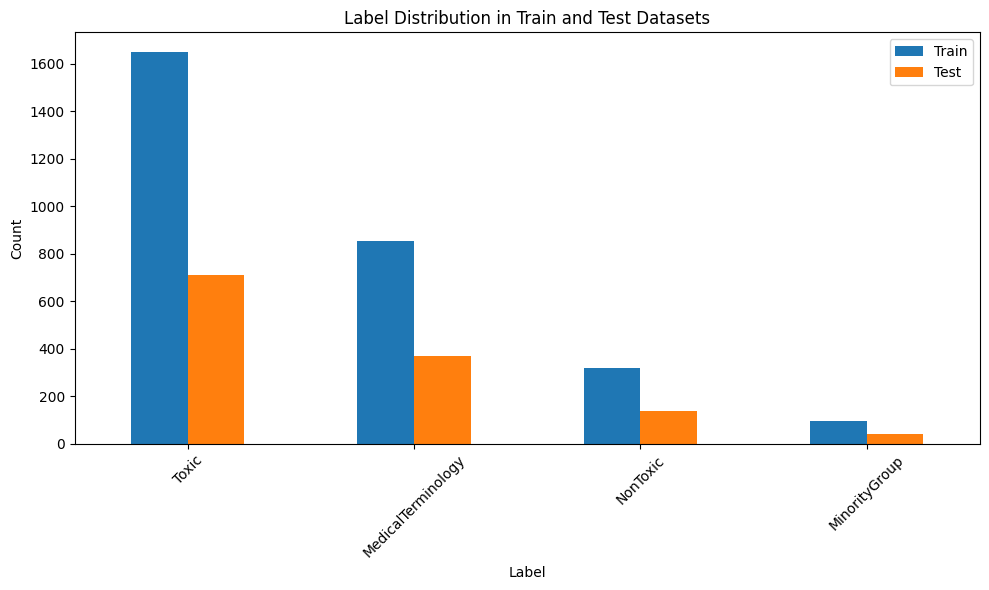

In [24]:
train_label_distribution = train_df[label_columns].sum()
print(train_label_distribution, '\n')
test_label_distribution = test_df[label_columns].sum()
print(test_label_distribution, '\n')

label_distribution_df = pd.DataFrame({
    "Train": train_label_distribution,
    "Test": test_label_distribution
})

ax = label_distribution_df.plot(kind='bar', figsize=(10, 6))
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Label Distribution in Train and Test Datasets')
plt.xticks(rotation=45)
plt.tight_layout()